# Data loader

In [1]:
import os 
import PIL
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# training features folder path
train_features_dir = '../data/segmentation_v1/train/images/data'
# training labels folder dir
train_labels_dir = '../data/segmentation_v1/train/masks/data'
# valid features folder path
valid_features_dir = '../data/segmentation_v1/valid/images/data'
# valid labels folder path
valid_labels_dir = '../data/segmentation_v1/valid/masks/data'

In [3]:
# check whether GPU is available
train_on_GPU = torch.cuda.is_available()
print(f'GPU is available: {train_on_GPU}')
batch_size = 4
print(f'The number of images in each iteration: {batch_size}')

GPU is available: True
The number of images in each iteration: 4


In [4]:
# built dataset class
class ActiveWFDataset(torch.utils.data.Dataset):
    """ A customized dataset for active whitecaps image segementation"""
    def __init__(self, features_dir, labels_dir):
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize([256,256]),
            torchvision.transforms.Normalize(
                mean=0.3374, std=0.1843)
        ])
        self.feature_folder = features_dir 
        self.labels_folder = labels_dir
        features = [PIL.Image.open(
            os.path.join(self.feature_folder, fname)).convert('L')
                    for fname in os.listdir(self.feature_folder)]
        labels = [PIL.Image.open(
            os.path.join(self.labels_folder, fname)).convert('L')
                    for fname in os.listdir(self.feature_folder)]
        # the filename of features and labels should be the same
        self.features = [self.transform(self.normalize_image(feature))
                         for feature in features]
        self.labels = [self.normalize_image(label)
                         for label in labels]
 
        
    def normalize_image(self, img):
        scaletransform = torchvision.transforms.Compose(
            [torchvision.transforms.Resize([256,256]),
             torchvision.transforms.PILToTensor()])
        img = scaletransform(img)
        return img.float() / 255
        
    def __getitem__(self, idx):
        feature, label = self.features[idx], self.labels[idx]
        return (feature, label)
    
    def __len__(self):
        return len(self.features)

In [5]:
active_train = ActiveWFDataset(train_features_dir, train_labels_dir)
train_iter = torch.utils.data.DataLoader(active_train, batch_size,
                                         shuffle=True,drop_last=True)

In [6]:
active_valid = ActiveWFDataset(valid_features_dir, valid_labels_dir)
valid_iter = torch.utils.data.DataLoader(active_valid, batch_size,
                                         shuffle=True,drop_last=True)

In [7]:
# A quick check of the dataloader
X, Y = next(iter(train_iter))
print(X.shape)
print(Y.shape)

torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


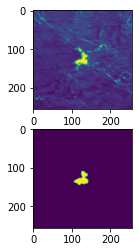

In [8]:
fig, axes = plt.subplots(2, 1)
axes[0].imshow(X[0].permute(1, 2, 0))
axes[1].imshow(Y[0].permute(1, 2, 0))

# Model

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional

In [10]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [11]:
model = UNet(n_channels=1, n_classes=1).float()
if train_on_GPU:
    model.cuda()

In [12]:
model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Loss Function

In [13]:
## BCEDiceLoss
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

# Optimizer

## RAdam Optimizer

In [14]:
import math
import torch
from torch.optim.optimizer import Optimizer

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# Setting of loss/optim

In [15]:
criterion = BCEDiceLoss(eps=1.0, activation=None)

optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

# Training Loop

In [16]:
from tqdm.auto import tqdm as tq

In [17]:
def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

In [18]:
# number of epochs to train the model
n_epochs = 200
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_iter, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        if train_on_GPU:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_iter, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_GPU:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_iter.dataset)
    valid_loss = valid_loss/len(valid_iter.dataset)
    dice_score = dice_score/len(valid_iter.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_200.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_34868\898393300.py:54: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1055.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 1  Training Loss: 0.821044  Validation Loss: 0.570665 Dice Score: 0.494614
Validation loss decreased (inf --> 0.570665).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 2  Training Loss: 0.542543  Validation Loss: 0.485807 Dice Score: 0.561015
Validation loss decreased (0.570665 --> 0.485807).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 3  Training Loss: 0.495063  Validation Loss: 0.486844 Dice Score: 0.559665


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 4  Training Loss: 0.467639  Validation Loss: 0.468763 Dice Score: 0.578168
Validation loss decreased (0.485807 --> 0.468763).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 5  Training Loss: 0.454162  Validation Loss: 0.402318 Dice Score: 0.640290
Validation loss decreased (0.468763 --> 0.402318).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 6  Training Loss: 0.413183  Validation Loss: 0.832222 Dice Score: 0.342513


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 7  Training Loss: 0.428837  Validation Loss: 0.474053 Dice Score: 0.578389


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 8  Training Loss: 0.397816  Validation Loss: 0.445270 Dice Score: 0.608662


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 9  Training Loss: 0.349197  Validation Loss: 0.337559 Dice Score: 0.698665
Validation loss decreased (0.402318 --> 0.337559).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 0.333061  Validation Loss: 0.326697 Dice Score: 0.705371
Validation loss decreased (0.337559 --> 0.326697).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 11  Training Loss: 0.322441  Validation Loss: 0.326548 Dice Score: 0.708615
Validation loss decreased (0.326697 --> 0.326548).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 12  Training Loss: 0.311838  Validation Loss: 0.341167 Dice Score: 0.693178


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 13  Training Loss: 0.295322  Validation Loss: 0.320314 Dice Score: 0.715549
Validation loss decreased (0.326548 --> 0.320314).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 14  Training Loss: 0.307772  Validation Loss: 0.311255 Dice Score: 0.719181
Validation loss decreased (0.320314 --> 0.311255).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 15  Training Loss: 0.291460  Validation Loss: 0.313395 Dice Score: 0.723019


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 16  Training Loss: 0.283213  Validation Loss: 0.322710 Dice Score: 0.710483


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 17  Training Loss: 0.279071  Validation Loss: 0.294413 Dice Score: 0.732610
Validation loss decreased (0.311255 --> 0.294413).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 18  Training Loss: 0.278061  Validation Loss: 0.323439 Dice Score: 0.711618


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 19  Training Loss: 0.274670  Validation Loss: 0.294358 Dice Score: 0.736374
Validation loss decreased (0.294413 --> 0.294358).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 20  Training Loss: 0.271121  Validation Loss: 0.271299 Dice Score: 0.754323
Validation loss decreased (0.294358 --> 0.271299).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 21  Training Loss: 0.267532  Validation Loss: 0.293753 Dice Score: 0.740227


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 22  Training Loss: 0.263947  Validation Loss: 0.287493 Dice Score: 0.741119


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 23  Training Loss: 0.256636  Validation Loss: 0.272160 Dice Score: 0.755366


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 24  Training Loss: 0.235264  Validation Loss: 0.262778 Dice Score: 0.763559
Validation loss decreased (0.271299 --> 0.262778).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 25  Training Loss: 0.238493  Validation Loss: 0.260026 Dice Score: 0.767869
Validation loss decreased (0.262778 --> 0.260026).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 26  Training Loss: 0.235486  Validation Loss: 0.253925 Dice Score: 0.767787
Validation loss decreased (0.260026 --> 0.253925).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 27  Training Loss: 0.230057  Validation Loss: 0.269708 Dice Score: 0.754893


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 28  Training Loss: 0.230639  Validation Loss: 0.252980 Dice Score: 0.771897
Validation loss decreased (0.253925 --> 0.252980).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 29  Training Loss: 0.223180  Validation Loss: 0.253161 Dice Score: 0.774807


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 30  Training Loss: 0.222757  Validation Loss: 0.241760 Dice Score: 0.782399
Validation loss decreased (0.252980 --> 0.241760).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 31  Training Loss: 0.223032  Validation Loss: 0.253625 Dice Score: 0.772029


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 32  Training Loss: 0.226925  Validation Loss: 0.248902 Dice Score: 0.777614


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 33  Training Loss: 0.219470  Validation Loss: 0.248316 Dice Score: 0.776776


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 34  Training Loss: 0.219776  Validation Loss: 0.250858 Dice Score: 0.773445


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 35  Training Loss: 0.213486  Validation Loss: 0.249684 Dice Score: 0.776584


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 36  Training Loss: 0.219140  Validation Loss: 0.235719 Dice Score: 0.788183
Validation loss decreased (0.241760 --> 0.235719).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 37  Training Loss: 0.213315  Validation Loss: 0.235061 Dice Score: 0.788759
Validation loss decreased (0.235719 --> 0.235061).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 38  Training Loss: 0.218562  Validation Loss: 0.258391 Dice Score: 0.772187


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 39  Training Loss: 0.214560  Validation Loss: 0.247307 Dice Score: 0.775005


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 40  Training Loss: 0.215898  Validation Loss: 0.251559 Dice Score: 0.772803


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 41  Training Loss: 0.210305  Validation Loss: 0.241239 Dice Score: 0.782723


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 42  Training Loss: 0.215198  Validation Loss: 0.257284 Dice Score: 0.765201


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 43  Training Loss: 0.213953  Validation Loss: 0.244827 Dice Score: 0.779702


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 44  Training Loss: 0.212965  Validation Loss: 0.243488 Dice Score: 0.778260


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 45  Training Loss: 0.213581  Validation Loss: 0.249527 Dice Score: 0.774793


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 46  Training Loss: 0.215322  Validation Loss: 0.236787 Dice Score: 0.785948


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 47  Training Loss: 0.208767  Validation Loss: 0.254479 Dice Score: 0.770340


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 48  Training Loss: 0.215652  Validation Loss: 0.247632 Dice Score: 0.779635


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 49  Training Loss: 0.213144  Validation Loss: 0.248370 Dice Score: 0.778132


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 50  Training Loss: 0.217684  Validation Loss: 0.242559 Dice Score: 0.781329


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 51  Training Loss: 0.216953  Validation Loss: 0.241639 Dice Score: 0.780544


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 52  Training Loss: 0.214005  Validation Loss: 0.250221 Dice Score: 0.776759


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 53  Training Loss: 0.207219  Validation Loss: 0.252088 Dice Score: 0.770832


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 54  Training Loss: 0.212749  Validation Loss: 0.234311 Dice Score: 0.787584
Validation loss decreased (0.235061 --> 0.234311).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 55  Training Loss: 0.214640  Validation Loss: 0.236777 Dice Score: 0.786133


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 56  Training Loss: 0.209893  Validation Loss: 0.244565 Dice Score: 0.780151


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 57  Training Loss: 0.212955  Validation Loss: 0.242953 Dice Score: 0.780509


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 58  Training Loss: 0.210761  Validation Loss: 0.238999 Dice Score: 0.785267


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 59  Training Loss: 0.214968  Validation Loss: 0.242124 Dice Score: 0.781448


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 60  Training Loss: 0.216472  Validation Loss: 0.246052 Dice Score: 0.778400


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 61  Training Loss: 0.211521  Validation Loss: 0.248355 Dice Score: 0.776723


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 62  Training Loss: 0.218408  Validation Loss: 0.241305 Dice Score: 0.779968


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 63  Training Loss: 0.216527  Validation Loss: 0.249665 Dice Score: 0.774528


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 64  Training Loss: 0.209734  Validation Loss: 0.260198 Dice Score: 0.766505


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 65  Training Loss: 0.214878  Validation Loss: 0.242444 Dice Score: 0.779574


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 66  Training Loss: 0.214021  Validation Loss: 0.250754 Dice Score: 0.774495


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 67  Training Loss: 0.214232  Validation Loss: 0.250129 Dice Score: 0.775474


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 68  Training Loss: 0.210856  Validation Loss: 0.249680 Dice Score: 0.772417


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 69  Training Loss: 0.212521  Validation Loss: 0.243911 Dice Score: 0.779887


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 70  Training Loss: 0.215094  Validation Loss: 0.247190 Dice Score: 0.775729


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 71  Training Loss: 0.213304  Validation Loss: 0.248486 Dice Score: 0.777842


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 72  Training Loss: 0.216461  Validation Loss: 0.241758 Dice Score: 0.781743


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 73  Training Loss: 0.214987  Validation Loss: 0.246489 Dice Score: 0.778775


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 74  Training Loss: 0.215362  Validation Loss: 0.244297 Dice Score: 0.781007


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 75  Training Loss: 0.214640  Validation Loss: 0.244813 Dice Score: 0.779765


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 76  Training Loss: 0.210546  Validation Loss: 0.239072 Dice Score: 0.783650


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 77  Training Loss: 0.213729  Validation Loss: 0.236155 Dice Score: 0.788965


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 78  Training Loss: 0.211507  Validation Loss: 0.246825 Dice Score: 0.779058


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 79  Training Loss: 0.215686  Validation Loss: 0.250445 Dice Score: 0.774811


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 80  Training Loss: 0.213182  Validation Loss: 0.259126 Dice Score: 0.768384


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 81  Training Loss: 0.212702  Validation Loss: 0.236880 Dice Score: 0.787024


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 82  Training Loss: 0.214080  Validation Loss: 0.243816 Dice Score: 0.780033


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 83  Training Loss: 0.214003  Validation Loss: 0.246647 Dice Score: 0.778625


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 84  Training Loss: 0.210271  Validation Loss: 0.232864 Dice Score: 0.788325
Validation loss decreased (0.234311 --> 0.232864).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 85  Training Loss: 0.208971  Validation Loss: 0.242932 Dice Score: 0.782780


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 86  Training Loss: 0.216143  Validation Loss: 0.253257 Dice Score: 0.772141


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 87  Training Loss: 0.212602  Validation Loss: 0.251027 Dice Score: 0.774653


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 88  Training Loss: 0.212244  Validation Loss: 0.250905 Dice Score: 0.774247


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 89  Training Loss: 0.215822  Validation Loss: 0.243301 Dice Score: 0.779707


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 90  Training Loss: 0.212886  Validation Loss: 0.253413 Dice Score: 0.771988


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 91  Training Loss: 0.209723  Validation Loss: 0.235683 Dice Score: 0.786920


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 92  Training Loss: 0.215251  Validation Loss: 0.236927 Dice Score: 0.786108


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 93  Training Loss: 0.215992  Validation Loss: 0.251454 Dice Score: 0.772882


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 94  Training Loss: 0.215829  Validation Loss: 0.238923 Dice Score: 0.783436


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 95  Training Loss: 0.213071  Validation Loss: 0.250708 Dice Score: 0.773653


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 96  Training Loss: 0.212969  Validation Loss: 0.249555 Dice Score: 0.774956


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 97  Training Loss: 0.214959  Validation Loss: 0.251848 Dice Score: 0.774401


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 98  Training Loss: 0.218516  Validation Loss: 0.252005 Dice Score: 0.775593


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 99  Training Loss: 0.214194  Validation Loss: 0.256853 Dice Score: 0.769786


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 100  Training Loss: 0.215345  Validation Loss: 0.242671 Dice Score: 0.779998


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 101  Training Loss: 0.215335  Validation Loss: 0.242582 Dice Score: 0.782297


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 102  Training Loss: 0.211935  Validation Loss: 0.245971 Dice Score: 0.777349


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 103  Training Loss: 0.214058  Validation Loss: 0.237582 Dice Score: 0.784291


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 104  Training Loss: 0.212945  Validation Loss: 0.237564 Dice Score: 0.784348


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 105  Training Loss: 0.214522  Validation Loss: 0.234963 Dice Score: 0.788736


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 106  Training Loss: 0.214105  Validation Loss: 0.244991 Dice Score: 0.780761


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 107  Training Loss: 0.216283  Validation Loss: 0.236599 Dice Score: 0.785039


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 108  Training Loss: 0.215668  Validation Loss: 0.245221 Dice Score: 0.779844


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 109  Training Loss: 0.212217  Validation Loss: 0.247813 Dice Score: 0.777401


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 110  Training Loss: 0.213932  Validation Loss: 0.237545 Dice Score: 0.786457


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 111  Training Loss: 0.212282  Validation Loss: 0.241032 Dice Score: 0.781121


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 112  Training Loss: 0.212591  Validation Loss: 0.253373 Dice Score: 0.771792


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 113  Training Loss: 0.212057  Validation Loss: 0.247958 Dice Score: 0.775373


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 114  Training Loss: 0.210516  Validation Loss: 0.241523 Dice Score: 0.785877


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 115  Training Loss: 0.212778  Validation Loss: 0.235164 Dice Score: 0.787856


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 116  Training Loss: 0.213399  Validation Loss: 0.253704 Dice Score: 0.772314


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 117  Training Loss: 0.213747  Validation Loss: 0.253794 Dice Score: 0.773411


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 118  Training Loss: 0.214912  Validation Loss: 0.246766 Dice Score: 0.777628


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 119  Training Loss: 0.212178  Validation Loss: 0.237819 Dice Score: 0.784090


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 120  Training Loss: 0.216549  Validation Loss: 0.254979 Dice Score: 0.772146


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 121  Training Loss: 0.208319  Validation Loss: 0.239218 Dice Score: 0.786416


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 122  Training Loss: 0.213986  Validation Loss: 0.247952 Dice Score: 0.777357


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 123  Training Loss: 0.213348  Validation Loss: 0.246722 Dice Score: 0.776308


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 124  Training Loss: 0.215619  Validation Loss: 0.268449 Dice Score: 0.759942


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 125  Training Loss: 0.211959  Validation Loss: 0.248804 Dice Score: 0.775127


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 126  Training Loss: 0.215462  Validation Loss: 0.244250 Dice Score: 0.779469


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 127  Training Loss: 0.215387  Validation Loss: 0.248105 Dice Score: 0.775507


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 128  Training Loss: 0.212441  Validation Loss: 0.242608 Dice Score: 0.779944


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 129  Training Loss: 0.212793  Validation Loss: 0.257158 Dice Score: 0.765951


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 130  Training Loss: 0.208787  Validation Loss: 0.253116 Dice Score: 0.774713


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 131  Training Loss: 0.211315  Validation Loss: 0.237231 Dice Score: 0.782807


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 132  Training Loss: 0.214909  Validation Loss: 0.249865 Dice Score: 0.774736


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 133  Training Loss: 0.212409  Validation Loss: 0.245375 Dice Score: 0.778570


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 134  Training Loss: 0.211358  Validation Loss: 0.250555 Dice Score: 0.777305


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 135  Training Loss: 0.215021  Validation Loss: 0.250267 Dice Score: 0.778589


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 136  Training Loss: 0.214239  Validation Loss: 0.240948 Dice Score: 0.782803


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 137  Training Loss: 0.217204  Validation Loss: 0.249112 Dice Score: 0.777132


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 138  Training Loss: 0.213147  Validation Loss: 0.242715 Dice Score: 0.781203


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 139  Training Loss: 0.213686  Validation Loss: 0.251596 Dice Score: 0.771638


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 140  Training Loss: 0.214201  Validation Loss: 0.253322 Dice Score: 0.773589


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 141  Training Loss: 0.212396  Validation Loss: 0.243642 Dice Score: 0.782384


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 142  Training Loss: 0.213688  Validation Loss: 0.248031 Dice Score: 0.777319


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 143  Training Loss: 0.211992  Validation Loss: 0.244853 Dice Score: 0.777355


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 144  Training Loss: 0.212922  Validation Loss: 0.239973 Dice Score: 0.782658


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 145  Training Loss: 0.217735  Validation Loss: 0.248006 Dice Score: 0.777314


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 146  Training Loss: 0.214190  Validation Loss: 0.244039 Dice Score: 0.777791


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 147  Training Loss: 0.215628  Validation Loss: 0.242474 Dice Score: 0.783761


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 148  Training Loss: 0.214577  Validation Loss: 0.251391 Dice Score: 0.772564


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 149  Training Loss: 0.211831  Validation Loss: 0.239530 Dice Score: 0.783688


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 150  Training Loss: 0.213318  Validation Loss: 0.236902 Dice Score: 0.786288


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 151  Training Loss: 0.215402  Validation Loss: 0.235850 Dice Score: 0.788141


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 152  Training Loss: 0.212996  Validation Loss: 0.249052 Dice Score: 0.776135


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 153  Training Loss: 0.216989  Validation Loss: 0.246606 Dice Score: 0.778001


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 154  Training Loss: 0.212012  Validation Loss: 0.240913 Dice Score: 0.780735


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 155  Training Loss: 0.215215  Validation Loss: 0.258419 Dice Score: 0.767376


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 156  Training Loss: 0.215771  Validation Loss: 0.253643 Dice Score: 0.772162


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 157  Training Loss: 0.214762  Validation Loss: 0.246429 Dice Score: 0.779453


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 158  Training Loss: 0.214041  Validation Loss: 0.253745 Dice Score: 0.773252


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 159  Training Loss: 0.213614  Validation Loss: 0.246871 Dice Score: 0.777146


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 160  Training Loss: 0.209349  Validation Loss: 0.250288 Dice Score: 0.773730


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 161  Training Loss: 0.212688  Validation Loss: 0.239974 Dice Score: 0.783330


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 162  Training Loss: 0.208571  Validation Loss: 0.243420 Dice Score: 0.779383


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 163  Training Loss: 0.215245  Validation Loss: 0.247490 Dice Score: 0.778147


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 164  Training Loss: 0.212656  Validation Loss: 0.246159 Dice Score: 0.778454


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 165  Training Loss: 0.212238  Validation Loss: 0.250815 Dice Score: 0.775805


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 166  Training Loss: 0.214385  Validation Loss: 0.248893 Dice Score: 0.777724


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 167  Training Loss: 0.215037  Validation Loss: 0.250181 Dice Score: 0.772855


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 168  Training Loss: 0.216497  Validation Loss: 0.249401 Dice Score: 0.775662


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 169  Training Loss: 0.215110  Validation Loss: 0.242455 Dice Score: 0.781902


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 170  Training Loss: 0.214935  Validation Loss: 0.241665 Dice Score: 0.784244


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 171  Training Loss: 0.217510  Validation Loss: 0.242534 Dice Score: 0.780833


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 172  Training Loss: 0.214702  Validation Loss: 0.251940 Dice Score: 0.775147


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 173  Training Loss: 0.210041  Validation Loss: 0.245361 Dice Score: 0.779267


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 174  Training Loss: 0.211748  Validation Loss: 0.251496 Dice Score: 0.772980


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 175  Training Loss: 0.214009  Validation Loss: 0.248735 Dice Score: 0.778521


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 176  Training Loss: 0.210509  Validation Loss: 0.254591 Dice Score: 0.772795


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 177  Training Loss: 0.216018  Validation Loss: 0.244876 Dice Score: 0.778079


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 178  Training Loss: 0.213501  Validation Loss: 0.247490 Dice Score: 0.778045


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 179  Training Loss: 0.215804  Validation Loss: 0.244355 Dice Score: 0.780605


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 180  Training Loss: 0.211141  Validation Loss: 0.243948 Dice Score: 0.778264


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 181  Training Loss: 0.209353  Validation Loss: 0.253392 Dice Score: 0.771076


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 182  Training Loss: 0.214322  Validation Loss: 0.244786 Dice Score: 0.776514


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 183  Training Loss: 0.212915  Validation Loss: 0.247635 Dice Score: 0.776746


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 184  Training Loss: 0.211665  Validation Loss: 0.238556 Dice Score: 0.783091


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 185  Training Loss: 0.209841  Validation Loss: 0.253005 Dice Score: 0.771338


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 186  Training Loss: 0.213134  Validation Loss: 0.247078 Dice Score: 0.777016


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 187  Training Loss: 0.215316  Validation Loss: 0.239840 Dice Score: 0.782701


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 188  Training Loss: 0.210784  Validation Loss: 0.245314 Dice Score: 0.779219


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 189  Training Loss: 0.216406  Validation Loss: 0.244228 Dice Score: 0.781050


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 190  Training Loss: 0.210132  Validation Loss: 0.237589 Dice Score: 0.784679


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 191  Training Loss: 0.213077  Validation Loss: 0.237713 Dice Score: 0.785329


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 192  Training Loss: 0.211560  Validation Loss: 0.239139 Dice Score: 0.782388


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 193  Training Loss: 0.216033  Validation Loss: 0.248929 Dice Score: 0.776264


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 194  Training Loss: 0.213194  Validation Loss: 0.244524 Dice Score: 0.778948


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 195  Training Loss: 0.217219  Validation Loss: 0.249508 Dice Score: 0.775039


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 196  Training Loss: 0.213091  Validation Loss: 0.235365 Dice Score: 0.787511


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 197  Training Loss: 0.212758  Validation Loss: 0.237381 Dice Score: 0.787968


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 198  Training Loss: 0.209025  Validation Loss: 0.244311 Dice Score: 0.779618


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 199  Training Loss: 0.209649  Validation Loss: 0.251156 Dice Score: 0.774466


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 200  Training Loss: 0.215421  Validation Loss: 0.250310 Dice Score: 0.772938


# Plot Metrics

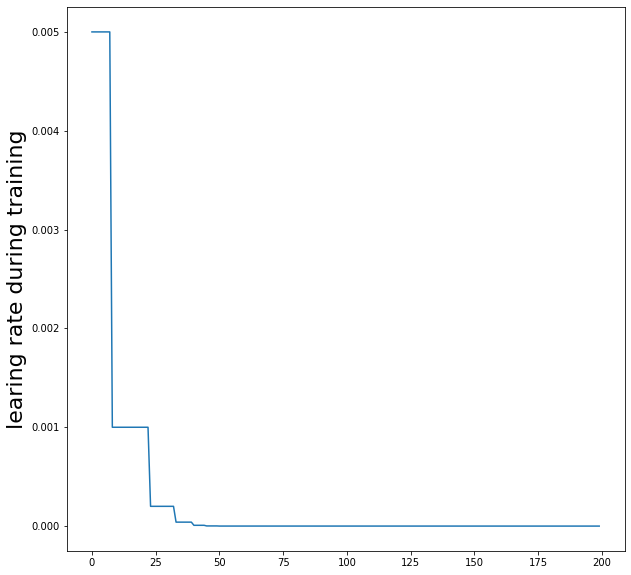

In [19]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

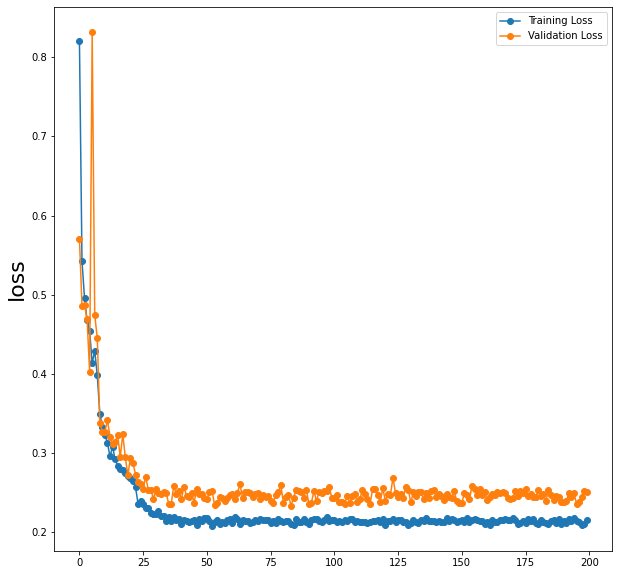

In [20]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

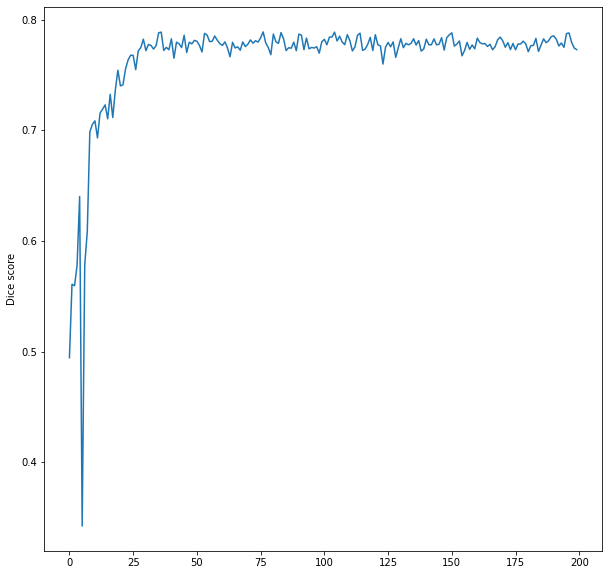

In [21]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

# Validation Results